In [1]:
# change the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:110% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime as dt
import time

In [3]:
sns.set()
sns.set_context(context='talk', font_scale=1.1)

In [4]:
%load_ext Cython

In [5]:
%%cython
# cython: infer_types=True

import numpy as np
import cython

@cython.cclass
class LowRankScoreSimulator:
    num_candidates: cython.int
    rank: cython.int
    num_feat: cython.int
    dim: cython.int
    vecs: np.float64[:, :, :]
    u: np.float64[:, :]
    e: np.float64[:]
    d: np.float64[:]
    
    def __init__(self, num_candidates: cython.int, rank: cython.int, num_fields: cython.int, dim: cython.int):
        self.num_candidates = num_candidates
        self.rank = rank
        self.num_feat = num_fields
        self.dim = dim
        self.vecs = np.random.normal(size=(num_candidates, num_fields, dim))
        self.u = np.random.normal(size=(rank, num_fields))
        self.e = np.random.normal(size=rank)
        self.d = -np.diag(self.u.T @ np.diag(self.e) @ self.u)
    
    def score(self, num_context_fields: cython.int):
        """ 
        Implements Algorithm 1 in the paper 
        """
        context_vecs = self.vecs[0, :num_context_fields, :]
        item_vecs = self.vecs[:, num_context_fields:, :]
        u_context = self.u[:, :num_context_fields]
        u_items = self.u[:, num_context_fields:]

        p_context = u_context @ context_vecs
        diag_score_context = np.square(context_vecs).sum(axis=-1) @ self.d[:num_context_fields]
        
        diag_score_items = np.square(item_vecs).sum(axis=-1) @ self.d[num_context_fields:]
        diag_score_part = diag_score_context + diag_score_items

        p = p_context[np.newaxis, :, :] + u_items @ item_vecs
        lowrank_score_part = np.square(p).sum(axis=-1) @ self.e

        return diag_score_part + lowrank_score_part

In [6]:
%%cython
# cython: infer_types=True

import numpy as np
import cython

@cython.cclass
class PrunedScoreSimulator:
    num_candidates: cython.int
    sparsity: cython.int
    num_feat: cython.int
    dim: cython.int
    vecs: np.float64[:, :, :]
    r: np.float64[:]
    i: np.int64[:]
    j: np.int64[:]
    
    def __init__(self, num_candidates: cython.int, rank_equiv: cython.int, num_fields: cython.int, dim: cython.int):
        self.num_candidates = num_candidates
        self.sparsity = rank_equiv * (num_fields + 1)
        self.num_feat = num_fields
        self.dim = dim
        self.vecs = np.random.normal(size=(num_fields, num_candidates, dim))
        
        self.r = np.random.normal(size=self.sparsity)
        
        i = np.tile(np.arange(num_fields), num_fields)
        j = np.repeat(np.arange(num_fields), num_fields)
        mask = i < j
        i = i[mask]
        j = j[mask]
        choices = np.random.choice(np.arange(len(i)), self.sparsity, replace=False)
        self.i = i[choices]
        self.j = j[choices]

    @cython.boundscheck(False)  # Deactivate bounds checking
    @cython.wraparound(False)   # Deactivate negative indexing.
    def score(self, num_context_fields: cython.int):
        """
        Implements Naive scoring using a sparse representation of the pruned matrix.
        """
        context_vecs = self.vecs[:num_context_fields, 0, :]
        context_r_mask = (self.i < num_context_fields) & (self.j < num_context_fields)
        
        context_i = self.i[context_r_mask]
        context_j = self.j[context_r_mask]
        context_r = self.r[context_r_mask]
        
        context_score: cython.double = 0.
        for i, j, r in zip(context_i, context_j, context_r):
            context_score += r * np.sum(context_vecs[i, :] * context_vecs[j, :])

        item_scores = np.full(self.num_candidates, context_score)
        item_i = self.i[~context_r_mask]
        item_j = self.j[~context_r_mask]
        item_r = self.r[~context_r_mask]
        for i, j, r in zip(item_i, item_j, item_r):
            item_scores += r * np.sum(self.vecs[i, :, :] * self.vecs[j, :, :], axis=1)
        
        return item_scores

In [7]:
%%cython
# cython: infer_types=True

import numpy as np
import cython

@cython.cclass
class FwFMScoreSimulator:
    num_candidates: cython.int
    num_feat: cython.int
    dim: cython.int
    vecs: np.float64[:, :, :]
    r: np.float64[:, :]
    
    def __init__(self, num_candidates: cython.int, num_fields: cython.int, dim: cython.int):
        self.num_candidates = num_candidates
        self.num_feat = num_fields
        self.dim = dim
        self.vecs = np.random.normal(size=(num_candidates, num_fields, dim))
        self.r = np.triu(np.random.normal(size=(num_fields, num_fields)))

    @cython.boundscheck(False)  # Deactivate bounds checking
    @cython.wraparound(False)   # Deactivate negative indexing.
    def score(self, num_context_fields: cython.int):
        """
        Implements direct FwFM scoring
        """
        context_vecs = self.vecs[0, :num_context_fields, :]
        item_vecs = self.vecs[:, num_context_fields:, :]

        context_r = self.r[:num_context_fields, :num_context_fields]
        context_item_r = self.r[:num_context_fields, num_context_fields:]
        item_item_r = self.r[num_context_fields:, num_context_fields:]
        
        context_score = np.sum((context_vecs @ context_vecs.T) * context_r)
        context_item_score = np.sum((context_vecs[np.newaxis, :, :] @ item_vecs.transpose(0, 2, 1)) * context_item_r, axis=(1, 2))
        item_item_score = np.sum((item_vecs @ item_vecs.transpose(0, 2, 1)) * item_item_r, axis=(1, 2))

        return context_score + context_item_score + item_item_score

In [8]:
results = []
score_count = 10
experiment_repeat = 50

In [9]:
class Benchmark:
    def __init__(self, results, model, num_ads, ranks, num_context_fields, count):
        self.results = results
        self.model = model
        self.num_ads = num_ads
        self.ranks = ranks
        self.num_context_fields = num_context_fields
        self.count = count
    
    # enter the context manager
    def __enter__(self):
        self.time_start = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        duration = time.perf_counter() - self.time_start
        for rank in self.ranks:
            result = {
                'Model': self.model,
                '# ads': self.num_ads,
                'Rank': rank,
                '# context fields': self.num_context_fields,
                'Scoring time (ms)': 1000 * duration / self.count
            }
            self.results.append(result)        
        return self

In [10]:
# compute low rank timings
for num_candidates in [5000, 10000]:
    for rank in [1, 2, 3]:
        x = dt.now().isoformat()
        print(f'Current ISO time: {x}, num_candidates = {num_candidates}, rank = {rank}')
        low_rank_sim = LowRankScoreSimulator(num_candidates=num_candidates, rank=rank, num_fields=40, dim=16)
        for num_context_fields in [10, 15, 20, 25, 30]:
            for i in range(experiment_repeat):
                with Benchmark(results, 'DPLR', num_candidates, [rank], num_context_fields, score_count) as benchmark:
                    for j in range(score_count):
                        low_rank_sim.score(num_context_fields)

Current ISO time: 2024-03-27T11:51:40.335602, num_candidates = 5000, rank = 1
Current ISO time: 2024-03-27T11:51:52.438619, num_candidates = 5000, rank = 2
Current ISO time: 2024-03-27T11:52:08.664404, num_candidates = 5000, rank = 3
Current ISO time: 2024-03-27T11:52:26.807726, num_candidates = 10000, rank = 1
Current ISO time: 2024-03-27T11:53:00.427308, num_candidates = 10000, rank = 2
Current ISO time: 2024-03-27T11:53:40.759801, num_candidates = 10000, rank = 3


In [11]:
# compute pruned timings
for num_candidates in [5000, 10000]:
    for rank in [1, 2, 3]:
        x = dt.now().isoformat()
        print(f'Current ISO: {x}, num_candidates = {num_candidates}, rank = {rank}')
        pruned_sim = PrunedScoreSimulator(num_candidates=num_candidates, rank_equiv=rank, num_fields=40, dim=16)
        for num_context_fields in [10, 15, 20, 25, 30]:
            for i in range(experiment_repeat):
                with Benchmark(results, 'Pruned', num_candidates, [rank], num_context_fields, score_count) as benchmark:
                    for j in range(score_count):
                        pruned_sim.score(num_context_fields)

Current ISO: 2024-03-27T11:54:26.313752, num_candidates = 5000, rank = 1
Current ISO: 2024-03-27T11:54:42.541192, num_candidates = 5000, rank = 2
Current ISO: 2024-03-27T11:55:16.055882, num_candidates = 5000, rank = 3
Current ISO: 2024-03-27T11:56:01.464207, num_candidates = 10000, rank = 1
Current ISO: 2024-03-27T11:56:27.050980, num_candidates = 10000, rank = 2
Current ISO: 2024-03-27T11:57:21.977602, num_candidates = 10000, rank = 3


In [12]:
# compute FwFM timings
for num_candidates in [5000, 10000]:
    x = dt.now().isoformat()
    print(f'Current ISO time: {x}, num_candidates = {num_candidates}')
    fwfm_sim = FwFMScoreSimulator(num_candidates=num_candidates, num_fields=40, dim=16)
    for num_context_fields in [10, 15, 20, 25, 30]:
        for i in range(experiment_repeat):
            with Benchmark(results, 'FwFM', num_candidates, [1, 2, 3], num_context_fields, score_count) as benchmark:
                for j in range(score_count):
                    fwfm_sim.score(num_context_fields)

Current ISO time: 2024-03-27T11:58:38.197475, num_candidates = 5000
Current ISO time: 2024-03-27T11:59:41.620240, num_candidates = 10000


In [13]:
results = pd.DataFrame.from_records(results)
results

,Model,# ads,Rank,# context fields,Scoring time (ms)
0,DPLR,5000,1,10,7.453511
1,DPLR,5000,1,10,7.231284
2,DPLR,5000,1,10,6.681201
3,DPLR,5000,1,10,6.756667
4,DPLR,5000,1,10,6.985379
...,...,...,...,...,...
4495,FwFM,10000,2,30,31.288140
4496,FwFM,10000,3,30,31.288140
4497,FwFM,10000,1,30,32.371540
4498,FwFM,10000,2,30,32.371540


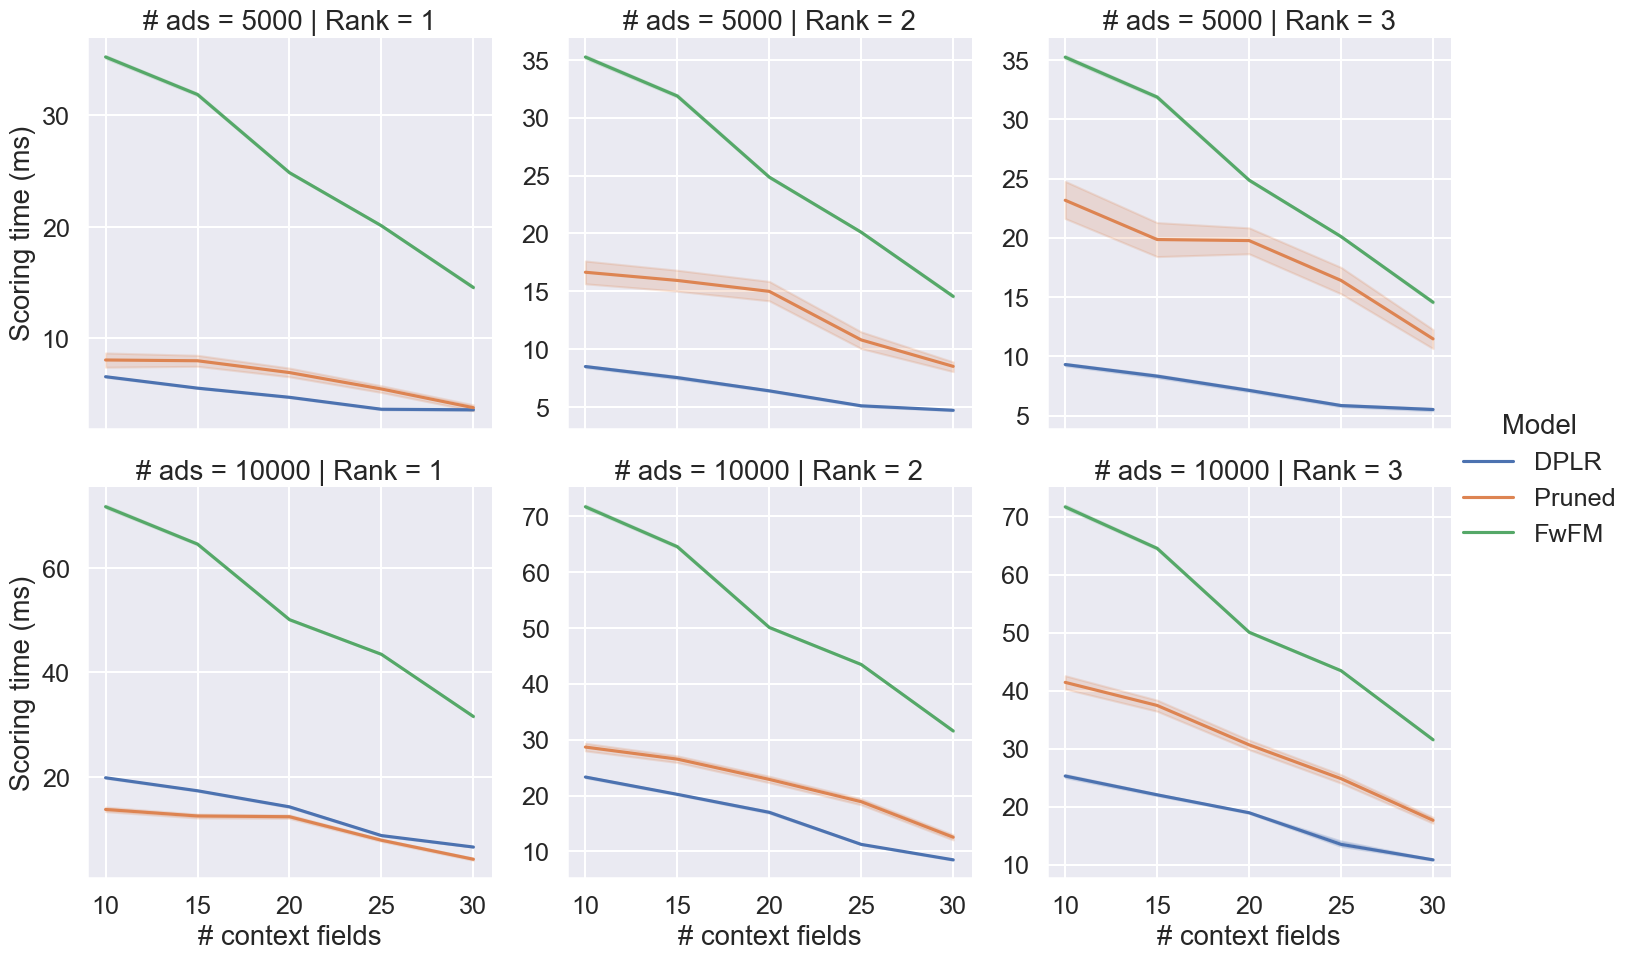

In [14]:
sns.relplot(data=results, x='# context fields', y='Scoring time (ms)', hue='Model', col='Rank', row='# ads', kind='line', facet_kws=dict(sharex=True, sharey=False))